In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import SeparableConv2D
from keras.layers import Input,Dropout, Dense,GlobalAvgPool2D, GlobalAveragePooling2D,Conv2D, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, AvgPool2D, Concatenate, MaxPool2D
from keras.models import Sequential,Model
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import time
import datetime
import os
import cv2
import io

import imutils
import matplotlib.pyplot as plt
from os import listdir

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

%matplotlib inline

In [3]:
# Set the path to the dataset
# dataset_path = "C:/Users/USER/ML/Latest/def_data"
dataset_path = "/content/gdrive/MyDrive/Google Colab"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "/content/gdrive/MyDrive/Google Colab/Training")
test_dir = os.path.join(dataset_path, "/content/gdrive/MyDrive/Google Colab/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

1321
1339
1595
1457


<ipython-input-4-34d7eaa87feb>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=train_df, x="Category", y="Count", palette = "Blues", legend=False)


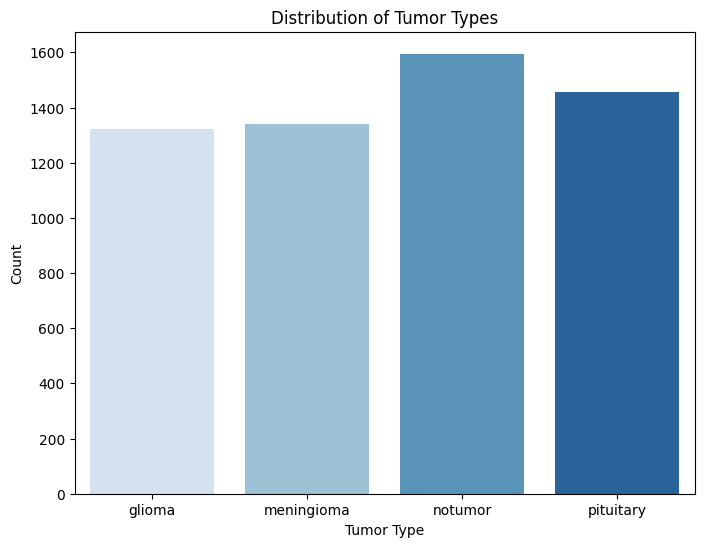

In [4]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count", palette = "Blues", legend=False)
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

300
306
405
300


<ipython-input-5-691c079eace0>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=test_df, x="Category", y="Count", palette = "Blues")


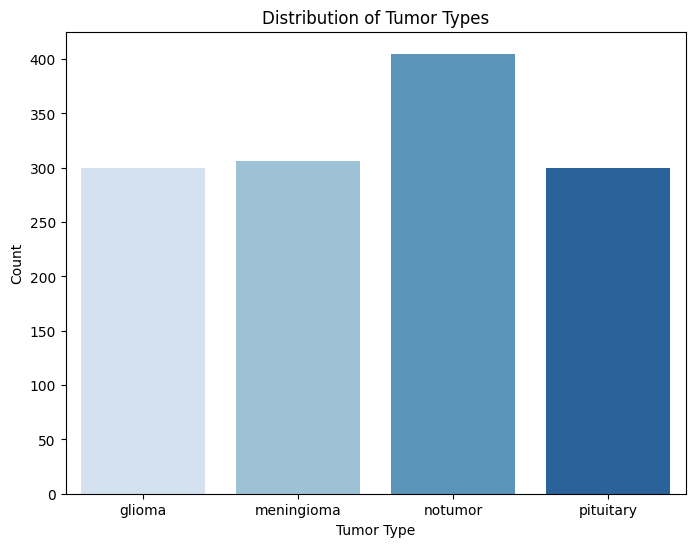

In [5]:
# Load and preprocess the dataset
test_data = []
for category in categories:
    folder_path = os.path.join(test_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    print(count)
    test_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

test_df = pd.concat(test_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=test_df, x="Category", y="Count", palette = "Blues")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

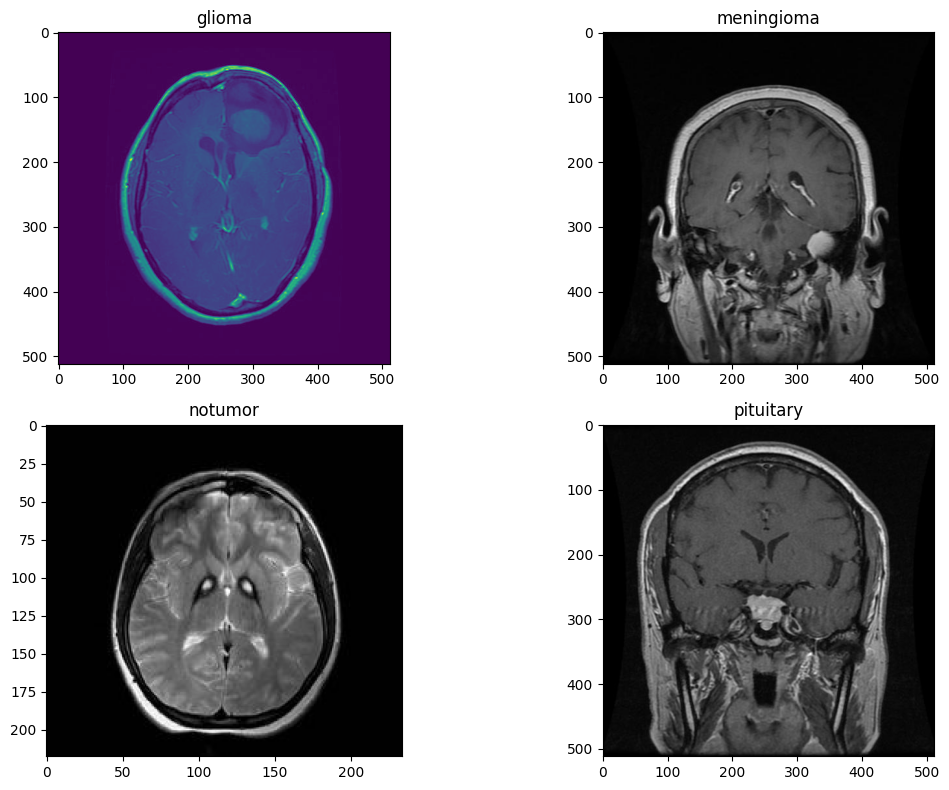

In [6]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("on")
plt.tight_layout()
plt.show()

In [7]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [8]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [9]:
# # Define the model architecture
# model = Sequential([
#     Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation="relu"),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation="relu"),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation="relu"),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(512, activation="relu"),
#     Dropout(0.5),
#     Dense(len(categories), activation="softmax")
# ])

# # Compile the model
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [10]:
def resnet(input_shape, n_classes):

  def conv_bn_rl(x, f, k=1, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x


  def identity_block(tensor, f):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)

    x = Add()([x, tensor])
    output = ReLU()(x)
    return output


  def conv_block(tensor, f, s):
    x = conv_bn_rl(tensor, f)
    x = conv_bn_rl(x, f, 3, s)
    x = Conv2D(4*f, 1)(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(4*f, 1, strides=s)(tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    output = ReLU()(x)
    return output


  def resnet_block(x, f, r, s=2):
    x = conv_block(x, f, s)
    for _ in range(r-1):
      x = identity_block(x, f)
    return x


  input = Input(input_shape)

  x = conv_bn_rl(input, 64, 7, 2)
  x = MaxPool2D(3, strides=2, padding='same')(x)

  x = resnet_block(x, 64, 3, 1)
  x = resnet_block(x, 128, 4)
  x = resnet_block(x, 256, 6)
  x = resnet_block(x, 512, 3)

  x = GlobalAvgPool2D()(x)

  output = Dense(n_classes, activation='softmax')(x)

  model = Model(input, output)
  return model

In [11]:
IMG_SHAPE = (150, 150, 3)

In [12]:
model = resnet(IMG_SHAPE, 4)

In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 75, 75, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 75, 75, 64)           0         ['batch_normalization[0][0

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/50
  1/178 [..............................] - ETA: 1:58:07 - loss: 2.4943 - accuracy: 0.2188

In [ ]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], '-o')
plt.plot(history.history['val_accuracy'], '-o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], '-o')
plt.plot(history.history['val_loss'], '-o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)

true_categories = test_generator.classes
print(true_categories)

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)   ##############
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)   ##############
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
model.save("Xception_brain_tumor_detection_model.h5")